### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete"
session_folder_name = abstracts_log_name.split('/')[-1]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[-1]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]17:58:59 Initiating the NLP Engine
[INFO]17:58:59 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete.txt is being ported to dataframe
[INFO]17:58:59 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/BarbaraData_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete.txt has been ported to dataframe
[INFO]17:58:59 Trimming data and preparing list of words
[['A seasonal rodent-borne disease surveillance program was established at Dagmar North Training Area located near the demilitarized zone, Republic of Korea, from 2001 through 2005. Selected habitats surveyed included earthen banks separating rice paddies, fighting positions along a 5 m rock-faced earthen berm, and extensive tall grasses with various degrees of herbaceous and scrub vegetation associated with dirt roads, rice paddies, ditches, ponds, or the Imjin River. Of the nine species of small mammals captured, the striped field mouse (Apodemus agrarius), the primary rese

[INFO]17:58:59 Generating bigrams
[INFO]17:58:59 Generating word bigrams
[INFO]17:58:59 Generated word bigrams
[INFO]17:59:0 Beginning lemmatization
[INFO]17:59:2 Ending lemmatization
[INFO]17:59:4 Issued perplexity: -7.743655730286011
[INFO]17:59:4 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.017*"disease" + 0.012*"cruzi" + 0.010*"transmission" + 0.009*"parasite" + 0.008*"reservoir" + 0.008*"vector" + 0.008*"virus" + 0.008*"human" + 0.007*"brasiliensis" + 0.007*"mammal"'),
 (1,
  '0.021*"mammal" + 0.018*"rat" + 0.016*"tick" + 0.015*"isolate" + 0.014*"sample" + 0.011*"mycobacteria" + 0.010*"sequence" + 0.010*"site" + 0.008*"tbe" + 0.008*"detect"'),
 (2,
  '0.011*"sleep" + 0.011*"ulceran" + 0.007*"nest" + 0.006*"ground" + 0.006*"undertake" + 0.006*"possum" + 0.005*"lonsdale" + 0.005*"htnv" + 0.005*"resistance" + 0.005*"point"'),
 (3,
  '0.024*"grey" + 0.015*"cat" + 0.011*"tabanid" + 0.010*"summer" + 0.009*"season" + 0.008*"light" + 0.007*"stripe" + 0.007*"polarization" + 0.007*"macaque" + 0.007*"strip"'),
 (4,
  '0.018*"animal" + 0.014*"plague" + 0.011*"year" + 0.010*"bacterium" + 0.010*"case" + 0.010*"flavicolli" + 0.010*"goat" + 0.009*"flea" + 0.009*"diagnose" + 0.009*"system"'),
 (5,
  '0.014*"prevalence" + 0.012*"parasite" + 0.011*"disease" + 0.011*"high" + 0.00

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(8,
  [('disease', 0.10231023102310231),
   ('abundance', 0.02838283828382838),
   ('increase', 0.026402640264026403),
   ('mammal', 0.022442244224422443),
   ('important', 0.02046204620462046),
   ('suggest', 0.018481848184818482),
   ('result', 0.01782178217821782),
   ('number', 0.01782178217821782),
   ('lyme', 0.0165016501650165),
   ('follow', 0.015181518151815182)]),
 (3,
  [('human', 0.05413313825896123),
   ('mammal', 0.03145574250182882),
   ('test', 0.029992684711046085),
   ('vector', 0.029992684711046085),
   ('site', 0.02487198244330651),
   ('trap', 0.021945866861741038),
   ('significant', 0.021945866861741038),
   ('mosquito', 0.02121433796634967),
   ('difference', 0.020482809070958303),
   ('include', 0.01755669348939283)]),
 (4,
  [('plague', 0.0422102839600921),
   ('year', 0.03069838833461243),
   ('rodent', 0.029930928626247123),
   ('colony', 0.02762854950115119),
   ('flea', 0.026093630084420567),
   ('increase', 0.023023791250959325),
   ('transmission', 0.01

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3351236849033587


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

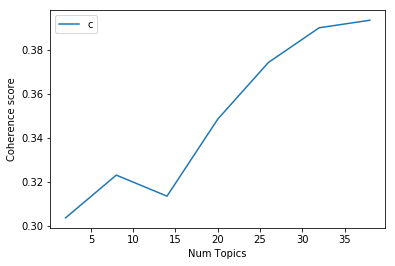

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.062*"population" + 0.026*"effect" + 0.023*"individual" + 0.023*"dynamic" '
  '+ 0.020*"datum" + 0.020*"squirrel" + 0.019*"system" + 0.018*"control" + '
  '0.018*"epidemic" + 0.017*"model" + 0.016*"rate" + 0.013*"determine" + '
  '0.013*"decline" + 0.013*"outbreak" + 0.011*"potentially" + 0.011*"red" + '
  '0.011*"process" + 0.011*"significantly" + 0.011*"impact" + '
  '0.010*"infectious" + 0.010*"measure" + 0.009*"size" + 0.009*"interaction" + '
  '0.009*"introduce" + 0.009*"influence" + 0.009*"survival" + 0.008*"native" + '
  '0.008*"support" + 0.007*"numerous" + 0.007*"extinction" + '
  '0.007*"persistence" + 0.006*"seasonal" + 0.006*"previous" + 0.006*"study" + '
  '0.006*"day" + 0.006*"management" + 0.006*"chronic_shedde" + 0.006*"lead" + '
  '0.006*"explore" + 0.006*"invasive"'),
 (1,
  '0.099*"tick" + 0.031*"collect" + 0.031*"infection" + 0.031*"mammal" + '
  '0.024*"rodent" + 0.021*"adult" + 0.020*"nymph" + 0.018*"larvae" + '
  '0.017*"ixode" + 0.016*"number" + 0.014*"

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.2750,"plague, year, rodent, colony, flea, increase, ...",[A seasonal rodent-borne disease surveillance ...
1,1,11.0,0.3797,"transmission, bat, potential, community, diver...",[Alterations in transmission of vector-borne z...
2,2,1.0,0.4179,"tick, collect, infection, mammal, rodent, adul...",[Although the importance of rodents as reservo...
3,3,6.0,0.3978,"host, pathogen, range, suggest, feed, reservoi...",[Amblyomma macula turn Koch is the primary vec...
4,4,10.0,0.1394,"disease, rat, human, animal, pathogen, urban, ...",[An inventory and monitoring program for speci...
5,5,2.0,0.3197,"virus, mammal, vector, distribution, show, hum...",[Avian influenza (AI) viruses primarily circul...
6,6,2.0,0.3262,"virus, mammal, vector, distribution, show, hum...",[Background: Aedes albopictus is an invasive s...
7,7,3.0,0.4454,"human, mammal, test, vector, site, trap, signi...",[Background: Mosquito-borne pathogens are of g...
8,8,8.0,0.2711,"disease, abundance, increase, mammal, importan...",[Background: The two most reported mosquito-bo...
9,9,8.0,0.3983,"disease, abundance, increase, mammal, importan...",[Bats are known reservoirs for numerous emergi...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"plague, year, rodent, colony, flea, increase, ...",9.0,0.0657
1,11.0,"transmission, bat, potential, community, diver...",18.0,0.1314
2,1.0,"tick, collect, infection, mammal, rodent, adul...",12.0,0.0876
3,6.0,"host, pathogen, range, suggest, feed, reservoi...",8.0,0.0584
4,10.0,"disease, rat, human, animal, pathogen, urban, ...",14.0,0.1022
5,2.0,"virus, mammal, vector, distribution, show, hum...",9.0,0.0657
6,2.0,"virus, mammal, vector, distribution, show, hum...",9.0,0.0657
7,3.0,"human, mammal, test, vector, site, trap, signi...",14.0,0.1022
8,8.0,"disease, abundance, increase, mammal, importan...",11.0,0.0803
9,8.0,"disease, abundance, increase, mammal, importan...",11.0,0.0803


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      25.456745        1       1 -0.134135 -0.105754
5      12.430760        1       2 -0.070437 -0.061705
1      10.861521        1       3 -0.113029  0.024451
6       9.551590        1       4 -0.175434  0.224133
11      9.226741        1       5 -0.068543 -0.046526
7       8.336827        1       6 -0.030791 -0.115829
0       8.202177        1       7 -0.025636 -0.037360
9       6.726794        1       8  0.102366 -0.047897
10      3.402982        1       9  0.120195  0.071783
4       3.120898        1      10  0.099042  0.039081
2       1.561462        1      11  0.148253  0.028989
3       1.121503        1      12  0.148149  0.026635, topic_info=     Category        Freq            Term       Total  loglift  logprob
3106  Default  149.000000            tick  149.000000  30.0000  30.0000
166   Default  231.000000            host  231.000000  29.0000  29.0000
3226  Default   37.000000         chigger   37.000000  28.0000  28.0000
2130  Default   69.000000          animal   69.000000  27.0000  27.0000
1902  Default   38.000000             bat   38.000000  26.0000  26.0000
209   Default   31.000000      bartonella   31.000000  25.0000  25.0000
1180  Default   29.000000          exotic   29.000000  24.0000  24.0000
2058  Default   25.000000          native   25.000000  23.0000  23.0000
2065  Default   38.000000             rat   38.000000  22.0000  22.0000
466   Default   27.000000          plague   27.000000  21.0000  21.0000
837   Default   39.000000         isolate   39.000000  20.0000  20.0000
523   Default  161.000000          mammal  161.000000  19.0000  19.0000
3189  Default   50.000000       reservoir   50.000000  18.0000  18.0000
2574  Default   63.000000          rodent   63.000000  17.0000  17.0000
1347  Default   47.000000           mouse   47.000000  16.0000  16.0000
1793  Default   83.000000          vector   83.000000  15.0000  15.0000
1686  Default   20.000000        squirrel   20.000000  14.0000  14.0000
1776  Default  127.000000           human  127.000000  13.0000  13.0000
1074  Default   54.000000        parasite   54.000000  12.0000  12.0000
506   Default   64.000000    transmission   64.000000  11.0000  11.0000
1763  Default   23.000000           nymph   23.000000  10.0000  10.0000
3143  Default   21.000000          larvae   21.000000   9.0000   9.0000
1664  Default   20.000000             dna   20.000000   8.0000   8.0000
3141  Default   76.000000      prevalence   76.000000   7.0000   7.0000
3202  Default   19.000000        mongoose   19.000000   6.0000   6.0000
2855  Default   19.000000       bacterial   19.000000   5.0000   5.0000
2790  Default   17.000000           cruzi   17.000000   4.0000   4.0000
840   Default   20.000000    mycobacteria   20.000000   3.0000   3.0000
3300  Default   63.000000          sample   63.000000   2.0000   2.0000
43    Default   66.000000         habitat   66.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
1286  Topic12    0.808870  attractiveness    1.551422   3.8392  -5.4655
2368  Topic12    0.808822         earthen    1.551392   3.8392  -5.4655
3166  Topic12    1.320677         macaque    2.573289   3.8235  -4.9752
1723  Topic12    0.552018      brightness    1.294473   3.6382  -5.8475
2497  Topic12    0.551999         striped    1.294456   3.6382  -5.8476
723   Topic12    0.552009         attract    1.294481   3.6382  -5.8475
1178  Topic12    0.551995     homogeneous    1.294495   3.6382  -5.8476
365   Topic12    0.551950            tall    1.294462   3.6381  -5.8476
1107  Topic12    0.551883         outdoor    1.294489   3.6380  -5.8478
33    Topic12    0.551882       holartica    1.294497   3.6380  -5.8478
2457  Topic12    0.551973        training    1.628495   3.4086  -5.8476
3041  Topic12    0.548642           subsp    1.718926   3.3485  -5.8537
999   Topic12    0.543799        

In [38]:
import dill

In [39]:
dill.dump_session('databases/BarbaraDataCompleteDataset.db')